# Working with FITS-cubes 

## Authors
[Dhanesh Krishnarao (DK)](http://www.astronomy.dk), [Shravan Shetty](http://www.astro.wisc.edu/our-people/post-doctoral-students/shetty-shravan/), [Diego Gonzalez-Casanova](http://www.astro.wisc.edu/our-people/graduate-students/gonzalez-casanova-diego/), [Audra Hernandez](http://www.astro.wisc.edu/our-people/scientists/hernandez-audra/)

## Learning Goals
* Find and download data using `astroquery`
* Read and plot slices across different dimensions of a data cube
* Compare different data sets (2D and 3D) by overploting contours
* Transform coordinate projections and match data resolutions with `reproject`
* Create intensity moment maps with spectral_cube

## Keywords
FITS-files, FITS-images, FITS-cubes, moment_maps, contours

In the tutorial we will visualize 2D and 3D data sets in different coordinates (galactic and equatorial). 

This tutorial will walk you though a simple visual analysis of the Small Magellanic Cloud (SMC) using HI 21cm emission and a Herschel 250 micron map. We will learn how to read in data from vizier, query and download matching data from Herschel using astroquery, and plot the resulting images in a multitude of ways. 

The primary libraries we will be using are: [astroquery](http://www.astropy.org/astroquery/), [spectral_cube](https://spectral-cube.readthedocs.io/en/latest/), [reproject](https://reproject.readthedocs.io/en/stable/#), [matplotlib](https://matplotlib.org/), and [aplpy](https://aplpy.github.io/)) 

They can be installed using conda:
- `conda install -c astropy astroquery`
- `conda install -c astropy spectral-cube`
- `conda install -c astropy reproject`
- `conda install -c astropy aplpy`

Alternatively, if you don't use conda, you can use pip.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits # We use fits to open the actual data file

import aplpy
from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

%matplotlib inline

## Download the HI Data

We will be using HI 21 cm emission data from the [HI4Pi survey](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1610.06175).  We want to look at neutral gas emission from the Magellanic Clouds, learn about the kinematics of the system and column densities. Using the vizier catalog, we have found a relevant data cube to use covering this region of the sky. You can also download an allsky data cube, but this is a very large file, so picking out sub-sections can be useful!

For us, the [relevant file is available via ftp from CDS Strasbourg](http://cdsarc.u-strasbg.fr/vizier/ftp/cats/J/A+A/594/A116/CUBES/GAL/TAN/TAN_C14.fits). 
This will be a FITS data cube in Galactic Coordinates using the Tangential Sky projection.

Sure, we can just download this file directly, but why do that when we can load it up via one line of code, and have it ready to use in our cache!

## Download the HI Fits Cube

In [2]:
#Downloads the HI data in a fits file format
hi_datafile = download_file(
    'http://cdsarc.u-strasbg.fr/vizier/ftp/cats/J/A+A/594/A116/CUBES/GAL/TAN/TAN_C14.fits',
    cache=True, show_progress = True)

 [Done]


Awesome, so now we have a copy of the data file (a FITS file).  So how do we do anything with it?

Lucky for us, the [spectral_cube](https://spectral-cube.readthedocs.io/en/latest/) package does a lot of the nitty gritty work for us to manipulate this data, and even quickly look through it. 
So let's open up our data file and read in the data as a SpectralCube!

The variable 'cube' has the data using SpectralCube and 'hi_data' is the data cube form the fits file without the special formating form SpectralCube

In [3]:
hi_data = fits.open(hi_datafile) # Open the FITS file for reading
cube = SpectralCube.read(hi_data) # Initiate a SpectralCube
hi_data.close() # Close the FITS file - we already read it in and don't need it anymore!

<div class="alert alert-info">
If you happen to already have the FITS file on your system, you can also skip the fits.open step and just directly read a FITS file with SpectralCube like this:


`
cube = SpectralCube.read(path_to_data_file/TAN_C14.fits') 
`
</div>

So what does this SpectralCube object actually look like? Let's find out!  The first check is to just print out the cube.

In [4]:
print(cube)

SpectralCube with shape=(933, 277, 269) and unit=K:
 n_x:    269  type_x: GLON-TAN  unit_x: deg    range:   286.707162 deg:  320.913024 deg
 n_y:    277  type_y: GLAT-TAN  unit_y: deg    range:   -51.659734 deg:  -28.394756 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s


### Some things to pay attention to here:

As we know, a data cube has three axes. In this case, there is Galactic Longitude (x), Galactic Latitude (y), and a spectral axis in terms a LSR Velocity (z - listed as s with spectral_cube).

The data hidden in the cube lives as an ndarray with shape (n_s, n_y, n_x) so that axis 0 corresponds with the Spectral Axis, axis 1 corresponds with the Galactic Latitude Axis, an daxis 2 corresponds with the Galactic Longitude Axis. 

When we `print(cube)`, we can see the shape, size, and units of all axes as well as the data stored in the cube. With this cube, the units of the data in the cube are temperatures (K). The spatial axes are in degrees, and the Spectral Axis is in (meters / second)

cube also contains information about the coordinates corresponding to the data in the form of a WCS (World Coordinate System) object. 

SpectralCube is clever and keeps all the data masked until you really need it so that you can work with large sets of data. So let's see what our data actually looks like!

SpectralCube has a `quicklook()` method which can give a handy sneak peak preview of the data.  It is useful when you just need to glance at a slice or spectrum without knowing any other information (say, to make sure the data isn't corrupted or is looking at the right region.  

To do this, we simply have to index our cube along one axis (for a slice) or two axes (for a spectrum):

INFO: Auto-setting vmin to -4.660e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.058e+01 [aplpy.core]


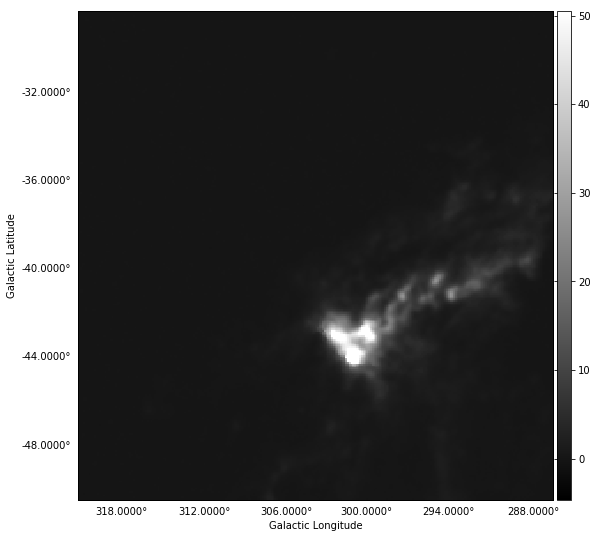

In [5]:
cube[600,:,:].quicklook() # Slice the cube along the spectral axis, and display a quick image

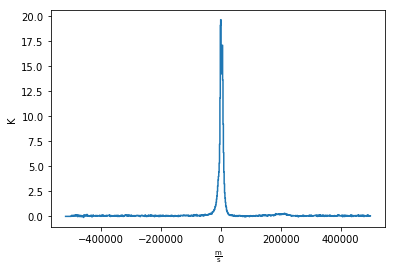

In [6]:
cube[:,150,150].quicklook() # Extract a single spectrum through the data cube

#### Try messing around with slicing the cube along different axes, or picking out different spectra

## Make a smaller cube, focusing on the Magellanic Clouds

The HI data cube we downloaded is bigger than we actually need it to be.  Let's try zooming in on just the part we need and make a new sub_cube. 

The easiest way to do this is just cut out part of cube with indices, but how do we know which index correpsponds with which coordinate value?

Well, we can extract the world coordinates from the cube using the .world() method. 
<div class="alert alert-warning">
Warning: using .world() will extract coordinates from every position you ask for. This can a TON of data if you don't slice through the cube.  One work around, is to slice along two axies, and extract coordinates just along a single dimension.
</div> 

The output of .world is an astropy Quanity which includes units. Extract these astropy Quantity objects by slicing the data.

In [7]:
_, b, _ = cube.world[0,:,0] #extract latitude world coordinates from cube
_, _, l = cube.world[0,0,:] #extract longitude world coordinates from cube

Now find the proper indices to cut our data along to extract a sub_cube

In [8]:
def find_nearest_idx(array, target_value): 
    '''Simple function to find the index closest to a target value'''
    idx = np.nanargmin(np.abs(array-target_value))
    return idx

# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg 
lon_range = [306, 295] * u.deg

# Find the correspond cube indicies for the longitude and latitude axes
# Make sure this output is sorted
lat_range_idx = sorted([find_nearest_idx(b, lat_range[0]), find_nearest_idx(b, lat_range[1])])
lon_range_idx = sorted([find_nearest_idx(l, lon_range[0]), find_nearest_idx(l, lon_range[1])])

# Create a sub_cube cut to these coordinates
sub_cube = cube[:,lat_range_idx[0]:lat_range_idx[1], lon_range_idx[0]:lon_range_idx[1]]

print(sub_cube)

SpectralCube with shape=(933, 75, 85) and unit=K:
 n_x:     85  type_x: GLON-TAN  unit_x: deg    range:   295.721832 deg:  305.875635 deg
 n_y:     75  type_y: GLAT-TAN  unit_y: deg    range:   -47.119860 deg:  -40.759196 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s


## Cut along the Spectral Axis:

We don't really need data from such a large velocity range so let's just extract a little slab. We can do this easily, in any units that we want using the .spectral_slab() method

In [9]:
sub_cube_slab = sub_cube.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

print(sub_cube_slab)

SpectralCube with shape=(467, 75, 85) and unit=K:
 n_x:     85  type_x: GLON-TAN  unit_x: deg    range:   295.721832 deg:  305.875635 deg
 n_y:     75  type_y: GLAT-TAN  unit_y: deg    range:   -47.119860 deg:  -40.759196 deg
 n_s:    467  type_s: VRAD      unit_s: m / s  range:  -300053.130 m / s:  300255.045 m / s


## Moment Maps

Moment maps are a useful analysis tool to study data cubes.  In short, a moment is a weighted integral along an axis (typically the Spectral Axis) that can give information about the total Intensity (or column density), mean velocity, or velocity dispersion along lines of sight. 

SpectralCube makes this very simple with the .moment() method. 
We can also convert to friendlier spectral units of km/s

Also, these new 2D projections can be saved as new fits files, complete with modified WCS information

In [10]:
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order = 0) # Zero-th moment 
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order = 1) # First moment

# Write the moments as a FITS image
#moment_0.write('hi_moment_0.fits') 
#moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ',moment_0.unit)
print('Moment_1 has units of: ',moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


## Display the Moment Maps (APLpy)

<div class="alert alert-warning">
Warning: APLpy will soon be depreciated, so ideally, the WCSAxes class should be used to display FITS images instead. See [below](#better_moments)
</div> 


[APLpy FITSFigure](http://aplpy.readthedocs.io/en/stable/api/aplpy.FITSFigure.html) provides one convenient way to quickly make plots of FITS data cube slices or of 2D FITS images

We'll first initial a figure with matplotlib, then add the APLpy FITSFigure as an axis object so we can manipulate labels, or overplot different things later on. 

the FITSFigure object provides a quick and convenient way to display FITS images as colorscale maps or contour plots. Let's try out both options and even a combined version

FITSFigure requires an HDU object as its argument which can easily be accessed with SpectralCube with `cube.hdu`

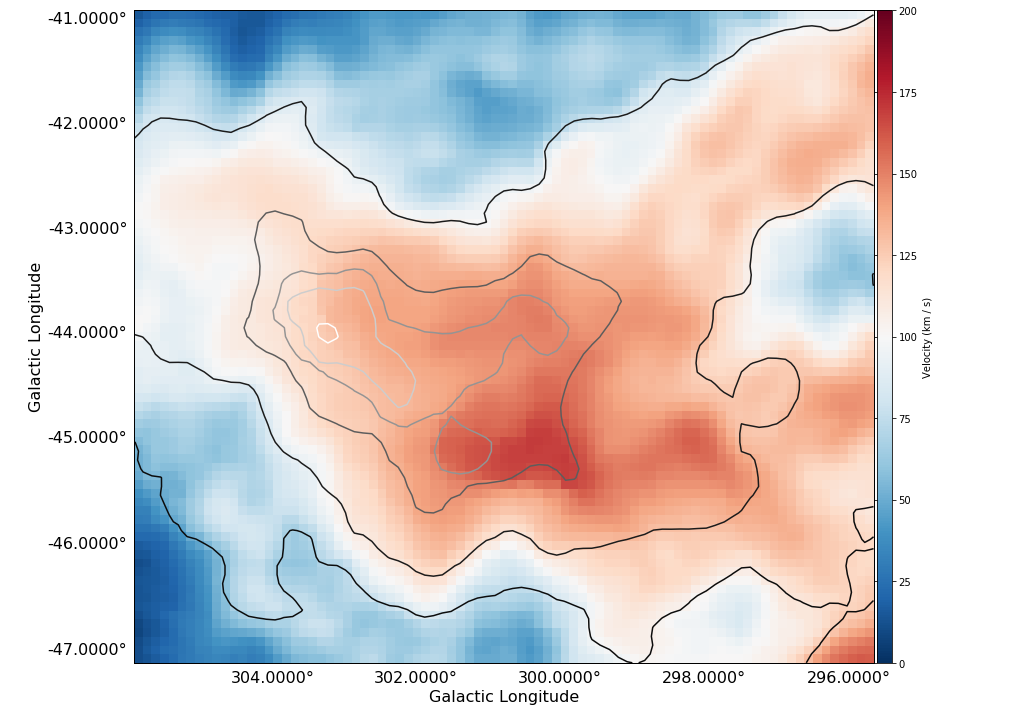

In [11]:
# Initiate a figure 
fig = plt.figure(figsize = (18,12))

# Initiate a FITSFigure to set up axes
F = aplpy.FITSFigure(moment_1.hdu, figure = fig)

# Extract the axis object that was created for future manipulation
ax = fig.gca()

# display a colorscale map of moment_1
F.show_colorscale(cmap = 'RdBu_r', vmin = 0., vmax = 200.)
# display a colorbar
F.show_colorbar(axis_label_text = 'Velocity (km / s)')

# overplot contours of hi_column_density (essentially column density here)
F.show_contour(hi_column_density.hdu, cmap = 'Greys_r', levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22))

ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_tick_params(labelsize = 16)
x_lab = ax.get_xlabel()
y_lab = ax.get_ylabel()
ax.set_xlabel(x_lab, fontsize = 16)
ax.set_ylabel(x_lab, fontsize = 16)


<a id='better_moments'></a>
## Display the Moment Maps (better)

The [WCSAxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/) framework in astropy allows us to easily display images with different coordinate axes and projections. It can do the same things that APLpy does, but in a more generalized and easy to streamline way. 

As long as we have a WCS object associated with the data, it is easy to transfer that projection to a matplotlib axis. SpectralCube makes it easy to access just the WCS object associated with a cube object. 

In [12]:
print(moment_1.wcs) # Examine the WCS object associated with the moment map

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 303.75  -40.0  
CRPIX : 18.5  86.8810191905518  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0833333333  0.0833333333  
NAXIS : 0  0


As expected, the first moment image we created only has two axes (Galactic Longitude and Galactic Latitude).  We can pass in this WCS object directly into a matplotlib axis instance

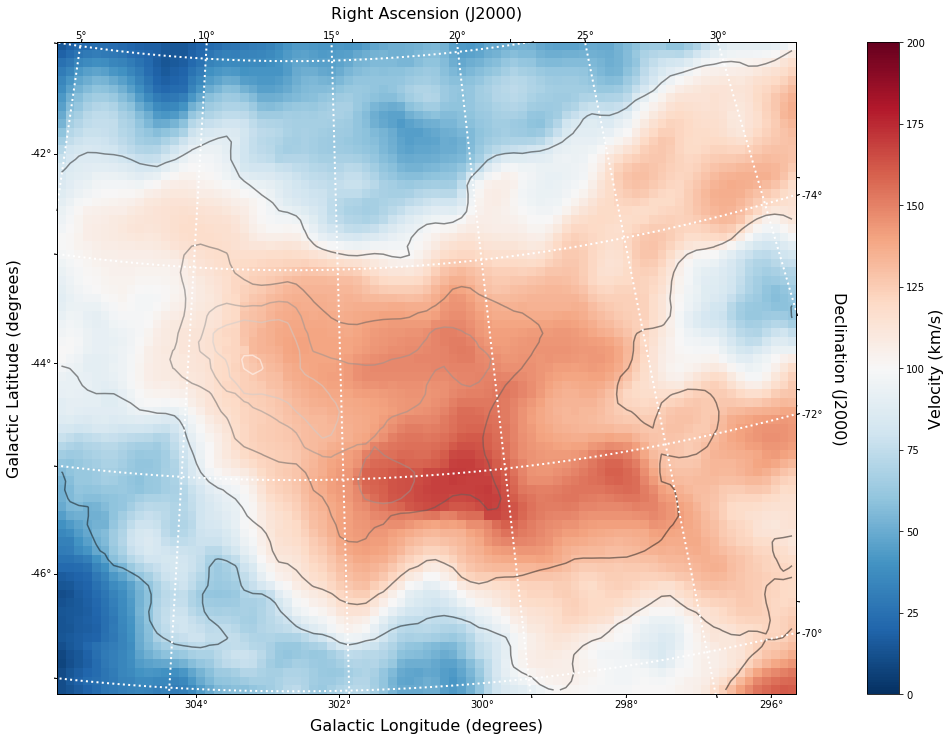

In [13]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize = (18,12))
ax = fig.add_subplot(111,projection = moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap = 'RdBu_r', vmin = 0, vmax = 200)
ax.invert_yaxis() # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize = 16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize = 16)

# Add a colorbar
cbar = plt.colorbar(im, pad = .07)
cbar.set_label('Velocity (km/s)', size = 16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw = 2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize = 16)
overlay[1].set_axislabel('Declination (J2000)', fontsize = 16)

# Overplot column density contours 
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22) # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap = 'Greys_r', alpha = 0.5, 
           lw = 3, levels = levels)

As you can see, the WCSAxes framework is very powerful and makes it as easy as making any matplotlib style plot. 

<a id='l-v slice'></a>
## Display a Longitude-Velocity Slice

The [WCSAxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/) framework in astropy also lets us slice the data accross different dimensions. It is often useful to slice along a single latitude and display an image showing longtitude and velocity information only (position-velocity or longitude-velocity diagram.)

This can be done by specifying the `slices` keyword and selecting the appropriate slice through the data. 

`slices` requires a 3D tuple containing the index to be sliced along and where we want the two axes to be displayed. This should be specified in the same order as the WCS object (longitude, latitude, velocity) as opposed to the order of numpy array holding the data  (velocity, latitude, longitude). 

We then select the appropriate data by indexing along the numpy array. 

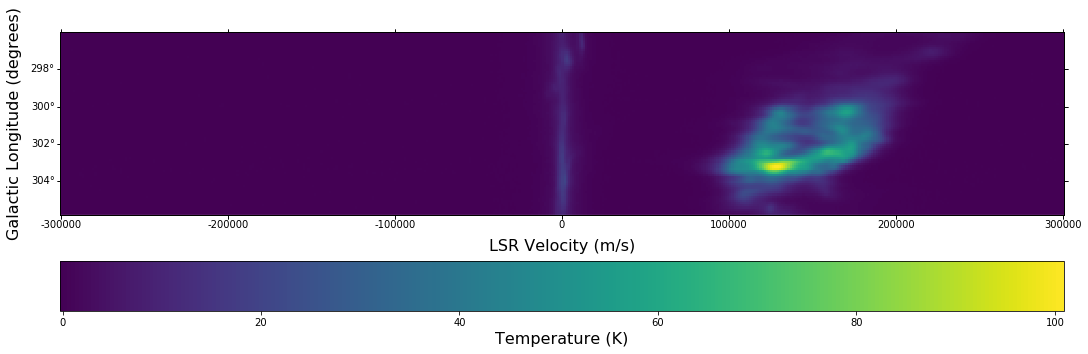

In [14]:
lat_slice = 35 # Index of latitude dimension to slice along

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize = (18,12))
ax = fig.add_subplot(111,projection = sub_cube_slab.wcs, slices = ('y', lat_slice, 'x'))
# Above, we have specified to plot the longitude along the y axis, pick just the lat_slice indicated, 
# and plot the velocity along the x axis

# Display the slice
im = ax.imshow(sub_cube_slab.hdu.data[:,lat_slice,:].transpose()) # Display the image slice
ax.invert_yaxis() # Flips the Y axis 

# Add axes labels
ax.set_xlabel("LSR Velocity (m/s)", fontsize = 16)
ax.set_ylabel("Galactic Longitude (degrees)", fontsize = 16)

# Add a colorbar
cbar = plt.colorbar(im, pad = .07, orientation = 'horizontal')
cbar.set_label('Temperature (K)', size = 16)



As we can see, the SMC seems to be only along positive velocities. 

## Try:
### Create a new spectral slab isolating just the SMC and slice along a different dimension to create a latitude-velocity diagram

## Find and Download a Herschel Image

This is great, but we want to compare the HI emission data with Herschel 350 micron emission to trace some dust. This can be done easily with [astroquery](http://www.astropy.org/astroquery/). 
We can query for the data by mission, take a quick look at the table of results, and download data after selecting a specific wavelength or filter. 

Since we are looking for Herschel data from an ESA mission, we will use the [astroquery.ESASky](http://astroquery.readthedocs.io/en/latest/esasky/esasky.html) class.

Specifically, the ESASKY.query_region_maps() method allows us to search for a specific region of the sky either using an astropy SkyCoord object or a string specifying an object name. In this case, we can just search for the SMC. A radius to search around the object can also be specified.

In [15]:
# Query for Herschel data in a 1 degree radius around the SMC
result = ESASky.query_region_maps('SMC', radius = 1*u.deg, missions = 'Herschel')

print(result)

TableList with 1 tables:
	'0:HERSCHEL' with 12 column(s) and 28 row(s) 


Here, result is a TableList which contains 24 Herschel data products that can be downloaded. We can see what information is available in this Table List by examining the keys in the Herschel Table

In [16]:
result['HERSCHEL'].keys()

['postcard_url',
 'product_url',
 'observation_id',
 'observation_oid',
 'ra_deg',
 'dec_deg',
 'target_name',
 'instrument',
 'filter',
 'start_time',
 'duration',
 'stc_s']

We want to find a 350 micron image, so we need to look closer at the filters used for these observations. 

In [17]:
result['HERSCHEL']['filter']

"70, 160"
"250, 350, 500"
"100, 160"
"100, 160"
"250, 350, 500"
"70, 160"
"70, 160"
"70, 160"
"100, 160"
"70, 160"
"70, 160"


Lucky for us, there is an observation made with three filters, 250,350, and 500 microns.  This is the object we will want to download. One way to do this is by making a boolean mask to select out the Table entry corresponding with the desired filter. Then, the ESASky.get_maps() method will download our data provided a TableList argument.

In [18]:
filters = result['HERSCHEL']['filter'].astype(str) # Convert the list of filters from the query to a string

# Construct a boolean mask, searching for only the desired filters
mask = np.array(['250, 350, 500' == s for s in filters], dtype = 'bool')

# Re-construct a new TableList object containing only our desired query entry
target_obs = TableList({"HERSCHEL":result['HERSCHEL'][mask]}) # This will be passed into ESASky.get_maps()

IR_images = ESASky.get_maps(target_obs) # Download the images
IR_images['HERSCHEL'][0]['350'].info() # Display some information about the 350 micron image

Starting download of HERSCHEL data. (5 files)

[Done]

[Done]

[Done]

[Done]

[Done]
INFO: Maps available at /home/circleci/project/tutorials/notebooks/FITS-cubes/Maps [astroquery.esasky.core]


Filename: Maps/HERSCHEL/AIOURL280822802/hspirepmw401_25pxmp_0110_m7303_1342198565_1342198566_1462476888800.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     184   ()      
  1  image         1 ImageHDU        47   (2407, 2141)   float64   
  2  error         1 ImageHDU        47   (2407, 2141)   float64   
  3  coverage      1 ImageHDU        47   (2407, 2141)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   84R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   65R x 4C   [1K, 27A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   450R x 10C   [1K, 20A, 13A, 196A, 1L, 1K, 1L, 74A, 11A, 41A]   


Since we are just doing some qualitative analysis, we only need the image, but you can easily access lots of other information from our downloaded object, such as errors. 

Let's go ahead and extract just the WCS information and image data from the 350 micron image. 

In [19]:
herschel_header = IR_images['HERSCHEL'][0]['350']['image'].header
herschel_wcs = WCS(IR_images['HERSCHEL'][0]['350']['image']) # Extract WCS information
herschel_imagehdu = IR_images['HERSCHEL'][0]['350']['image'] # Extract Image data
print(herschel_wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 18.99666058287459  -71.82876374906319  
CRPIX : 1063.0  1517.0  
NAXIS : 2407  2141


With this, it's just as easy as before to display this image using matplotlib with [WCSAxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) and the LogNorm() object so we can log scale our image. 

/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


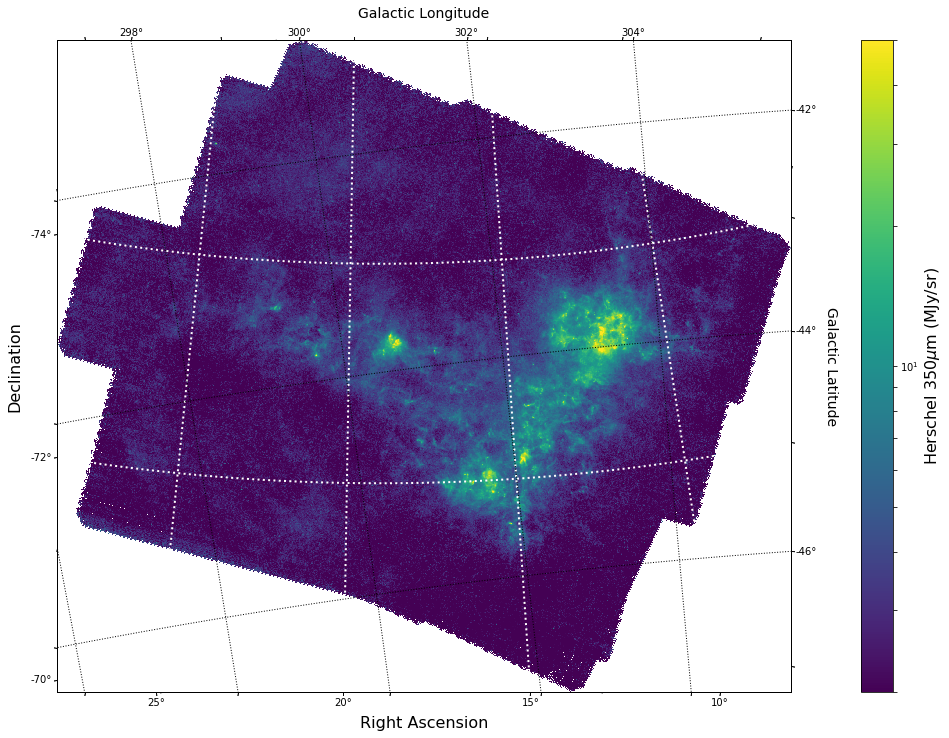

In [20]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize = (18,12))
ax = fig.add_subplot(111,projection = herschel_wcs)

# Display the moment map image
im = ax.imshow(herschel_imagehdu.data, cmap = 'viridis', 
               norm = LogNorm(), vmin = 2, vmax = 50)
#ax.invert_yaxis() # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize = 16)
ax.set_ylabel("Declination", fontsize = 16)
ax.grid(color = 'white', ls = 'dotted', lw = 2)

# Add a colorbar
cbar = plt.colorbar(im, pad = .07)
cbar.set_label(''.join(['Herschel 350'r'$\mu$m ','(', herschel_header['BUNIT'], ')']), size = 16)

# Overlay set of Galactic Coordinate Axes
overlay = ax.get_coords_overlay('galactic') 
overlay.grid(color='black', ls='dotted', lw = 1)
overlay[0].set_axislabel('Galactic Longitude', fontsize = 14)
overlay[1].set_axislabel('Galactic Latitude', fontsize = 14)

## Overlay HI 21 cm Contours on the IR 30 micron Image

To visually compare the neutral gas and dust as traced by HI 21 cm emission and IR 30 micron emission, we can use contours and colorscale images produced using the [WCSAxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) framework and the .get_transform() method. 

The [WCSAxes.get_transform()](http://docs.astropy.org/en/stable/api/astropy.visualization.wcsaxes.WCSAxes.html#astropy.visualization.wcsaxes.WCSAxes.get_transform) method returns a transformation from a specified frame to the pixel/data coordinates. It accepts a string specifying the frame or a wcs object. 

(2140.5, -0.5)

/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


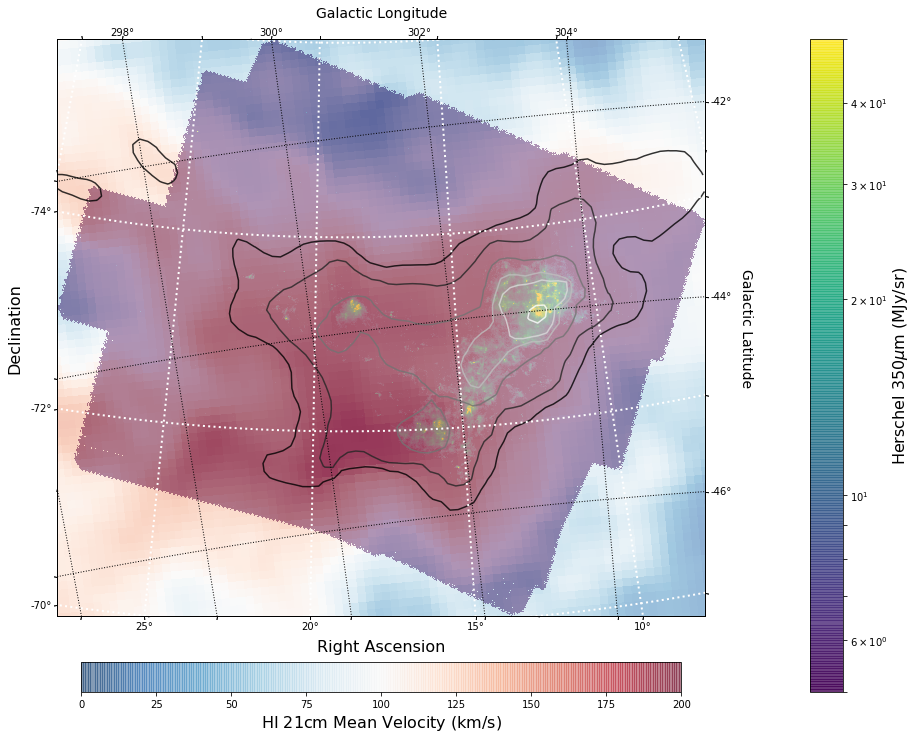

In [21]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize = (18,12))
ax = fig.add_subplot(111,projection = herschel_wcs)

# Display the moment map image
im = ax.imshow(herschel_imagehdu.data, cmap = 'viridis', 
               norm = LogNorm(), vmin = 5, vmax = 50, alpha = .8)
#ax.invert_yaxis() # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize = 16)
ax.set_ylabel("Declination", fontsize = 16)
ax.grid(color = 'white', ls = 'dotted', lw = 2)

# Extract x and y coordinate limits
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

# Add a colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=-0.1)
cbar.set_label(''.join(['Herschel 350'r'$\mu$m ','(', herschel_header['BUNIT'], ')']), size = 16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', ls='dotted', lw = 1)
overlay[0].set_axislabel('Galactic Longitude', fontsize = 14)
overlay[1].set_axislabel('Galactic Latitude', fontsize = 14)

hi_transform = ax.get_transform(hi_column_density.wcs) # extract axes Transform information for the HI data

# Overplot column density contours 
levels = (2e21, 3e21, 5e21, 7e21, 8e21, 1e22) # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap = 'Greys_r', alpha = 0.8, lw = 5, levels = levels,
           transform = hi_transform) # include the transform information with the keyword "transform"

# Overplot velocity image so we can also see the Gas velocities
im_hi = ax.imshow(moment_1.hdu.data, cmap = 'RdBu_r', vmin = 0, vmax = 200, alpha = 0.5, transform = hi_transform)

# Add a second colorbar for the HI Velocity information
cbar_hi = plt.colorbar(im_hi, orientation = 'horizontal', fraction=0.046, pad=0.07)
cbar_hi.set_label('HI 'r'$21$cm Mean Velocity (km/s)', size = 16)

# Apply original image x and y coordinate limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

## Using reproject to match image resolutions

The [reproject](https://reproject.readthedocs.io/en/stable/) package is a powerful tool allowing for image data to be transformed into a variety of projections and resolutions.  It's most powerful use is in fact to transform data from one map projection to another without losing any information and properly conserving flux values within the data. It even has a method to perform a fast reprojection if you are not too concerned with the absolute accuracy of the data values. 

A simple use of the reproject package is to simply scale down (or up) resolutions of an image artificially. This could be a useful step if you are trying to get emission line ratios or directly compare the Intensity or Flux from on tracer to that of another tracer in the same physical pointing of the sky. 

From our previously made images, it should be clear that the IR Herschel image has a higher spatial resolution than that of the HI data cube. We can look more into this by taking a better look at both header objects and using reproject to downscale the Herschel Image. 

In [22]:
print('IR Resolution (dx,dy) = ', herschel_header['cdelt1'], herschel_header['cdelt2'])

print('HI Resolution (dx,dy) = ', hi_column_density.hdu.header['cdelt1'], hi_column_density.hdu.header['cdelt1'])

IR Resolution (dx,dy) =  -0.002777777777778 0.002777777777777778
HI Resolution (dx,dy) =  -0.0833333333 -0.0833333333


<div class="alert alert-info">
Note: Different ways of accessing the header are shown above corresponding to the different object types (coming from SpectralCube vs astropy.io.fits)
</div> 

As we can see, the IR data has over 10 times higher spatial resolution. In order to create a new projection of an image, all we need to specifiy is a new header containing WCS information to transform into.  These can be created manually if you wanted to completely change something about the projection type (i.e. going from a Mercator map projection to a Tangential map projection). For us, since we want to match our resolutions, we can just "steal" the WCS object from the HI data. Specifically, we will be using the [reproject_interp()](https://reproject.readthedocs.io/en/stable/api/reproject.reproject_interp.html#reproject.reproject_interp) function. This takes two arguments: an HDU object that you want to reproject, and a header containing WCS information to reproject onto. 

In [23]:
rescaled_herschel_data, _ = reproject_interp(herschel_imagehdu, 
                                             # reproject the Herschal image to match the HI data
                                             hi_column_density.hdu.header) 

rescaled_herschel_imagehdu = fits.PrimaryHDU(data = rescaled_herschel_data, 
                                             # wrap up our reprojection as a new fits HDU object
                                             header = hi_column_density.hdu.header)

`rescaled_herschel_imagehdu` will now behave just like the other fits images we have been working with, but now with a degraded resolution matching the HI data. This includes having its native coordinates in Galactic rather than RA and Dec. 

(74.5, -0.5)

/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


/home/circleci/project/venv/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


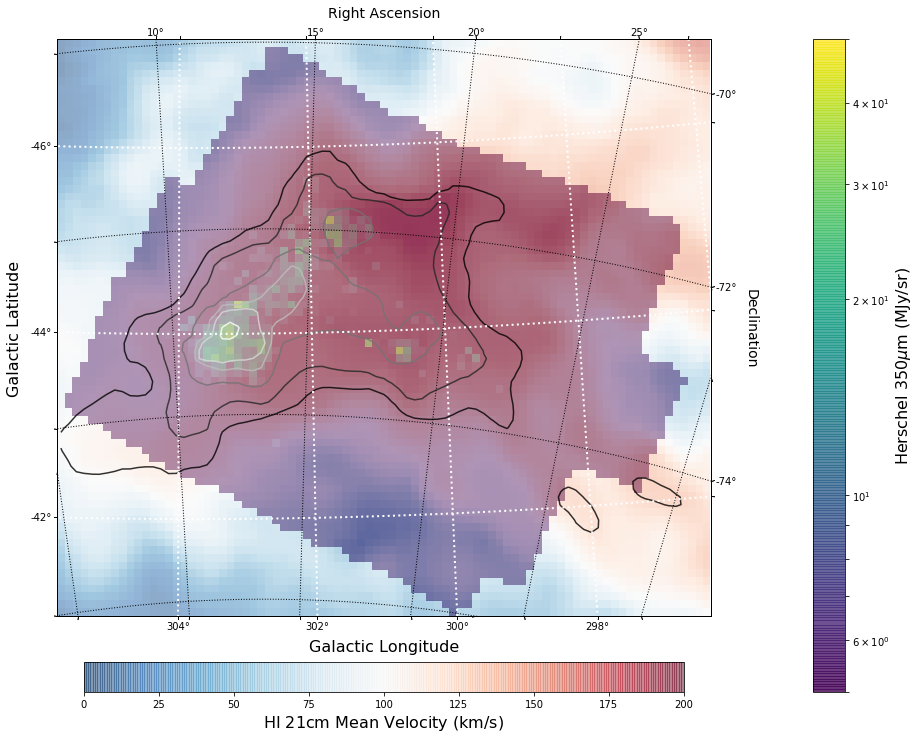

In [24]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize = (18,12))
ax = fig.add_subplot(111,projection = WCS(rescaled_herschel_imagehdu))

# Display the moment map image
im = ax.imshow(rescaled_herschel_imagehdu.data, cmap = 'viridis', 
               norm = LogNorm(), vmin = 5, vmax = 50, alpha = .8)
#ax.invert_yaxis() # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude", fontsize = 16)
ax.set_ylabel("Galactic Latitude", fontsize = 16)
ax.grid(color = 'white', ls = 'dotted', lw = 2)

# Extract x and y coordinate limits
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

# Add a colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=-0.1)
cbar.set_label(''.join(['Herschel 350'r'$\mu$m ','(', herschel_header['BUNIT'], ')']), size = 16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='black', ls='dotted', lw = 1)
overlay[0].set_axislabel('Right Ascension', fontsize = 14)
overlay[1].set_axislabel('Declination', fontsize = 14)

hi_transform = ax.get_transform(hi_column_density.wcs) # extract axes Transform information for the HI data

# Overplot column density contours 
levels = (2e21, 3e21, 5e21, 7e21, 8e21, 1e22) # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap = 'Greys_r', alpha = 0.8, lw = 5, levels = levels,
           transform = hi_transform) # include the transform information with the keyword "transform"

# Overplot velocity image so we can also see the Gas velocities
im_hi = ax.imshow(moment_1.hdu.data, cmap = 'RdBu_r', vmin = 0, vmax = 200, alpha = 0.5, transform = hi_transform)

# Add a second colorbar for the HI Velocity information
cbar_hi = plt.colorbar(im_hi, orientation = 'horizontal', fraction=0.046, pad=0.07)
cbar_hi.set_label('HI 'r'$21$cm Mean Velocity (km/s)', size = 16)

# Apply original image x and y coordinate limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

The real power of reproject is in actually changing the map projection used to display the data.  This is done by creating a WCS object that contains a different projection type such as `CTYPE : 'RA---CAR'  'DEC--CAR'` as opposed to `CTYPE : 'RA---TAN'  'DEC--TAN'`. 

## Challenge:

Use [reproject](https://reproject.readthedocs.io/en/stable/#) and WCS to create a new WCS object in a different map projection and see distortions in the image can change. 